In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

## FUNCTIONS TO GENERATE TRAIN AND TESTING DATA

In [ ]:
# #generating thousand images of normally distributed histograms

# for i in range(0, 1000):
#     rand = np.random.randint(20, 1000)
#     data = np.random.randn(rand)

#     path = os.path.join('images', 'normal', f'image_{i}.png')

#     plt.figure()

#     plt.hist(data)
#     plt.axis('off')



#     plt.savefig(path, bbox_inches='tight', pad_inches=0)
#     plt.close()

    

In [ ]:
# for i in range(0,1000):
#     rand = np.random.randint(0,4)
#     rand_int = np.random.randint(20, 1000)

#     path = os.path.join('images', 'not_normal', f'image_{i}.png')

#     distributions = ['exponential', 'gamma', 'uniform', 'else']

#     if distributions[rand] == 'exponential':
#         data = np.random.uniform(0, 1, rand_int)
#     if distributions[rand] == 'gamma':
#         data = np.random.gamma(2,2,rand_int)
#     if distributions[rand] == 'uniform':
#         data = np.random.uniform(0, 1, rand_int)
#     else:
#         data = np.random.rand(rand_int)

#     plt.hist(data)
#     plt.axis('off')

#     plt.savefig(path, bbox_inches='tight', pad_inches=0)
#     plt.close()

    

# Generating Images from new data

In [58]:
def generate_image(data):
    plt.hist(data)
    plt.axis('off')

    path = os.path.join("new_image.png")
    plt.savefig(path, bbox_inches = 'tight',pad_inches = 0)
    plt.close()

    return path

## IMAGE DEPENDENCIES

In [2]:
import cv2
import tensorflow as tf
import os
 
path = os.path.join('images')

In [3]:
data = tf.keras.utils.image_dataset_from_directory(path, image_size=(369,496))

Found 2000 files belonging to 2 classes.


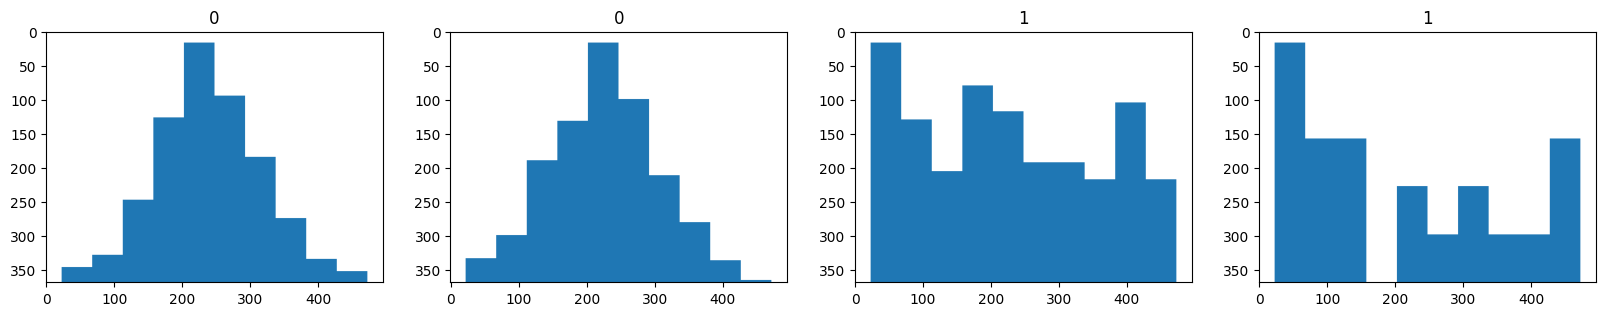

In [4]:
data_iterator = data.as_numpy_iterator()
batch= data_iterator.next()
batch[0].shape

fig, ax = plt.subplots(ncols = 4, figsize = (20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

This shows that, data with normal distributions are labeled "0" and data with any other distributions are labelled "1"

# Preprocessing of data

In [5]:
scaled_data = data.map(lambda x,y: (x/255, y))
len(scaled_data)

63

In [6]:
train_size = int(0.5 * len(scaled_data))
test_size = int(0.3 * len(scaled_data))
val_size = int(0.2 * len(scaled_data)) +2

print(train_size, test_size, val_size)

train = scaled_data.take(train_size)
val = scaled_data.skip(train_size).take(val_size)
test = scaled_data.skip(train_size+val_size).take(test_size)

31 18 14


# DEEP LEARNING MODEL

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

batch[0].shape

(32, 369, 496, 3)

In [8]:
model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(369,496,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 367, 494, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 183, 247, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 181, 245, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 90, 122, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 88, 120, 16)       4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 44, 60, 16)        0

# TRAINING

In [10]:
from tensorflow import keras

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.accuracy = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accuracy.append(logs.get('accuracy'))

loss_history = LossHistory()


In [13]:
type(train)

tensorflow.python.data.ops.take_op._TakeDataset

In [12]:
hist = model.fit(train,
                epochs=1, 
                validation_data=val, 
                callbacks=[loss_history]
                )

31/31 [==============================] - 101s 3s/step - loss: 0.1470 - accuracy: 0.9375 - val_loss: 0.0132 - val_accuracy: 0.9955


## PLOT OF TRAINING PERFORMANCE ON EACH BATCH

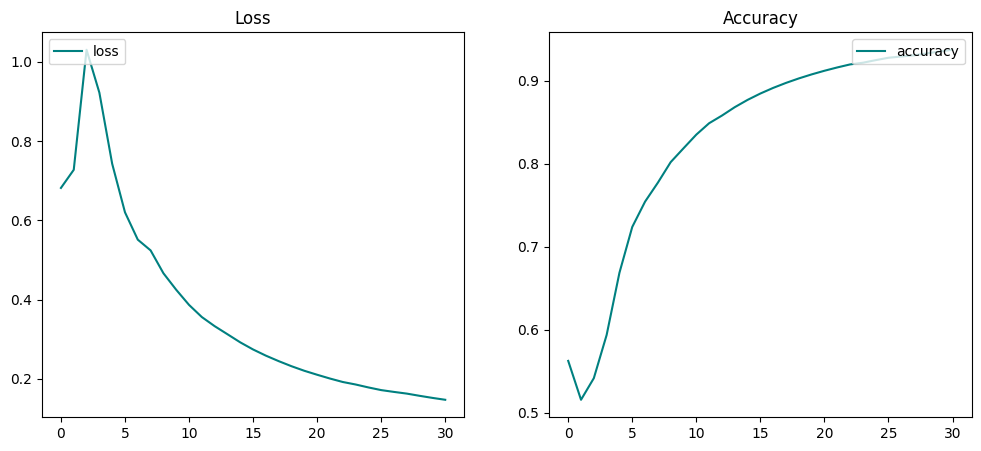

In [15]:
import pandas as pd

performance = pd.DataFrame({'loss': loss_history.losses, 'accuracy': loss_history.accuracy})

plt.figure(figsize=(12, 5))

# subplot for loss
plt.subplot(1, 2, 1)
plt.plot(performance['loss'], color='teal', label='loss')
plt.legend(loc="upper left")
plt.title('Loss')

# subplot for accuracy
plt.subplot(1, 2, 2)
plt.plot(performance['accuracy'], color='teal', label='accuracy')
plt.legend(loc="upper right")
plt.title('Accuracy')

plt.show()

# EVALUATING ON TEST 

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)


In [19]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.99666667, shape=(), dtype=float32) tf.Tensor(0.9982143, shape=(), dtype=float32)


## TESTING ON DATA GENERATED FROM CANONICAL SMILES

In [20]:
import pandas as pd
test_path = os.path.join('External_testing', 'test_sample.csv')

test_data = pd.read_csv(test_path)
cols = test_data.columns

In [69]:
test_data

,GATS3se,GATS4se,GATS5se,ABCGG,SpAbs_A,VR3_A,nAromAtom,nHeavyAtom
0,0.928960,0.870847,1.132416,9.201443,17.149050,4.789768,6,14
1,0.948406,0.690433,0.977338,15.439912,32.469770,7.766395,13,25
2,1.818819,0.525650,1.657219,12.603728,NaN,NaN,0,19
3,1.256165,1.804700,1.401020,12.268100,NaN,NaN,6,18
4,1.259166,1.192638,0.805854,17.870076,36.528270,6.506648,15,29
...,...,...,...,...,...,...,...,...
2099,0.991572,0.940497,1.394053,16.675758,32.963854,6.678264,15,26
2100,0.899511,1.203562,1.216364,16.373610,36.890704,7.228840,18,29
2101,1.164072,1.055857,0.836039,18.100251,40.553762,7.465863,21,30
2102,1.019849,1.051548,1.641117,15.657518,35.974599,6.218469,6,28


In [74]:
len(cols)

8

In [67]:
def process_input(image_path):
    img = cv2.imread(image_path) / 255
    try:
        return img.reshape(1, 369,496,3)
    except:
        return "Invalid image path or shape of image is wrong"

In [80]:
fig, ax = plt.subplots(ncols = 4, figsize = (20,20))

for i in range(int(len(cols)/2)):
    print(i)

0
1
2
3
